In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import sys
import time

In [2]:
# import pytorch modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [3]:
# plotting
sys.path.insert(0,'..')
from utilz import plot_stroke

In [4]:
# find gpu
cuda = torch.cuda.is_available()

In [1]:
# hyperparamters
timesteps = 300
num_clusters = 20
cell_size = 400
nlayers = 2
bsize = 100
init_lr = 1E-2

In [2]:
# prepare training data
train_data = np.load('train_data.npy')
train_data = torch.from_numpy(train_data)
if cuda:
    train_data = train_data.cuda()
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=bsize, shuffle=True)
    
# prepare validation data
validation_data = np.load('validation_data.npy')
validation_data = torch.from_numpy(validation_data)
if cuda:
    validation_data = validation_data.cuda()
validation_loader = torch.utils.data.DataLoader(
    validation_data, batch_size=bsize, shuffle=True)

NameError: name 'np' is not defined

In [3]:
# 2-layer lstm with mixture of gaussian parameters as outputs
# skip connections added
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = 3, hidden_size = cell_size, num_layers = 1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size = cell_size+3, hidden_size = cell_size, num_layers = 1, batch_first=True)
        self.linear1 = nn.Linear(cell_size*2, 1+ num_clusters*6)
        self.tanh = nn.Tanh()
        
    def forward(self, x, prev, prev2):
        timesteps = x.shape[1]
        h1, (h1_n, c1_n) = self.lstm(x, prev)
        x2 = torch.cat([h1, x], dim=-1)
        h2, (h2_n, c2_n) = self.lstm2(x2, prev2)
        h = torch.cat([h1, h2], dim=-1)
        params = self.linear1(h)
        weights = F.softmax(params.narrow(-1, 0, num_clusters), dim=-1)
        mu_1 = params.narrow(-1, num_clusters, num_clusters)
        mu_2 = params.narrow(-1, 2*num_clusters, num_clusters)
        log_sigma_1 = params.narrow(-1, 3*num_clusters, num_clusters)
        log_sigma_2 = params.narrow(-1, 4*num_clusters, num_clusters)
        p = self.tanh(params.narrow(-1, 5*num_clusters, num_clusters))
        end = F.sigmoid(params.narrow(-1, 6*num_clusters, 1))
        
        return end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, (h1_n, c1_n), (h2_n, c2_n)

NameError: name 'nn' is not defined

In [4]:
# training objective
def log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, x):
    timesteps = x.shape[1]
    x_0 = x.narrow(-1,0,1)
    x_1 = x.narrow(-1,1,1)
    x_2 = x.narrow(-1,2,1)
    end_loglik = (x_0*end + (1-x_0)*(1-end)).log()
    const = 1E-20
    pi_term = torch.Tensor([2*np.pi])
    if cuda:
        pi_term = pi_term.cuda()
    pi_term = -Variable(pi_term, requires_grad = False).log()
    z = (x_1 - mu_1)**2/(log_sigma_1.exp()**2)\
        + ((x_2 - mu_2)**2/(log_sigma_2.exp()**2)) \
        - 2*p*(x_1-mu_1)*(x_2-mu_2)/((log_sigma_1 + log_sigma_2).exp())
    mog_lik1 =  pi_term -log_sigma_1 - log_sigma_2 - 0.5*((1-p**2).log())
    mog_lik2 = z/(2*(1-p**2))
    mog_lik = (weights.log() + (mog_lik1 - mog_lik2)).exp().sum(dim=-1)
    return end_loglik.sum() + (mog_lik+const).log().sum()

In [36]:
def decay_learning_rate(optimizer, decay = 1.01):
    state_dict = optimizer.state_dict()
    lr = state_dict['param_groups'][0]['lr']
    lr /= decay
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)
    return optimizer

In [37]:
def save_checkpoint(epoch, model, validation_loss, optimizer, filename='best.pt'):
    checkpoint=({'epoch': epoch+1,
    'model': model.state_dict(),
    'validation_loss': validation_loss,
    'optimizer' : optimizer.state_dict()
    })
    torch.save(checkpoint, filename)

In [69]:
model = LSTM()
if cuda:
    model = model.cuda()

In [70]:
epochs = 20
optimizer = optim.Adam([
                {'params':model.parameters()},
            ], lr=init_lr)
state = torch.load('epoch_20_s1.pt')
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])

In [71]:
# training
h1_init, c1_init = torch.zeros((1,bsize,cell_size)), torch.zeros((1,bsize,cell_size))
zero_tensor = torch.zeros((bsize, 1, 3))
h2_init, c2_init = torch.zeros((1,bsize,cell_size)), torch.zeros((1,bsize,cell_size))

h1_init2, c1_init2 = torch.zeros((1, bsize,cell_size)),\
                    torch.zeros((1,bsize,cell_size))
h2_init2, c2_init2 = torch.zeros((1, bsize,cell_size)),\
                    torch.zeros((1,bsize,cell_size))
zero_tensor2 = torch.zeros((bsize, 1, 3))
if cuda:
    h1_init = h1_init.cuda()
    c1_init = c1_init.cuda()
    h2_init = h2_init.cuda()
    c2_init = c2_init.cuda()
    zero_tensor = zero_tensor.cuda()
    h1_init2 = h1_init2.cuda()
    c1_init2 = c1_init2.cuda()
    h2_init2 = h2_init2.cuda()
    c2_init2 = c2_init2.cuda()
    zero_tensor2 = zero_tensor2.cuda()
h1_init, c1_init = Variable(h1_init), Variable(c1_init)
h2_init, c2_init = Variable(h2_init), Variable(c2_init)
h1_init2, c1_init2 = Variable(h1_init2), Variable(c1_init2)
h2_init2, c2_init2 = Variable(h2_init2), Variable(c2_init2)


# t_loss = []
# v_loss = []
# best_validation_loss = 1E10

start_time = time.time()
# for epoch in range(epochs):
for epoch in range(20,40):
    train_loss =0
    for batch_idx, data in enumerate(train_loader):
        step_back = torch.cat([zero_tensor, data.narrow(1,0,timesteps-1)], 1)
        x = Variable(step_back, requires_grad=False)
        optimizer.zero_grad()
        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2 = model(x, (h1_init, c1_init), \
                                                                                    (h2_init, c2_init))
        y = Variable(data, requires_grad=False)
        loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, y)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 60 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))
        
        

    print('====> Epoch: {} Average train loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))
    t_loss.append(train_loss / len(train_loader.dataset))
    
    # validation
    # prepare validation data
    validation_samples = list(enumerate(validation_loader))[0][1]
    step_back2 = torch.cat([zero_tensor2, validation_samples.narrow(1,0,timesteps-1)], 1)
    x2 = Variable(step_back2, requires_grad=False)
    y2 = Variable(validation_samples, requires_grad = False)

    end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2= model(x2, (h1_init2, c1_init2), \
                                                                              (h2_init2, c2_init2))
    loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, y2)
    validation_loss = loss.data[0]
    print('====> Epoch: {} Average validation loss: {:.4f}'.format(
          epoch+1, validation_loss / bsize))
    v_loss.append(validation_loss)

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        save_checkpoint(epoch, model, validation_loss, optimizer)
    
    # learning rate annealing
    optimizer = decay_learning_rate(optimizer, 1.03)
    
    # checkpoint model and training
    #if (epochs+1)%5 == 0:
    filename = 'epoch_{}_s1.pt'.format(epoch+1)
    save_checkpoint(epoch, model, validation_loss, optimizer, filename)

    # testing checkpoints
    state = torch.load(filename)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    
    print('wall time: {}s'.format(time.time()-start_time))

Train Epoch: 21 [0/54000 (0%)]	Loss: -197.986738
Train Epoch: 21 [6000/54000 (11%)]	Loss: -209.002734
Train Epoch: 21 [12000/54000 (22%)]	Loss: -179.582480
Train Epoch: 21 [18000/54000 (33%)]	Loss: -186.395059
Train Epoch: 21 [24000/54000 (44%)]	Loss: -213.359414
Train Epoch: 21 [30000/54000 (56%)]	Loss: -188.313359
Train Epoch: 21 [36000/54000 (67%)]	Loss: -190.208027
Train Epoch: 21 [42000/54000 (78%)]	Loss: -192.054512
Train Epoch: 21 [48000/54000 (89%)]	Loss: -198.807324
====> Epoch: 21 Average train loss: -196.8340
====> Epoch: 21 Average validation loss: 13.7037
wall time: 226.76070761680603s
Train Epoch: 22 [0/54000 (0%)]	Loss: -202.763359
Train Epoch: 22 [6000/54000 (11%)]	Loss: -209.960039
Train Epoch: 22 [12000/54000 (22%)]	Loss: -207.518398
Train Epoch: 22 [18000/54000 (33%)]	Loss: -209.350586
Train Epoch: 22 [24000/54000 (44%)]	Loss: -183.652559
Train Epoch: 22 [30000/54000 (56%)]	Loss: -206.597617
Train Epoch: 22 [36000/54000 (67%)]	Loss: -200.692656
Train Epoch: 22 [42000

Train Epoch: 34 [36000/54000 (67%)]	Loss: -252.738379
Train Epoch: 34 [42000/54000 (78%)]	Loss: -268.817969
Train Epoch: 34 [48000/54000 (89%)]	Loss: -267.031602
====> Epoch: 34 Average train loss: -257.0646
====> Epoch: 34 Average validation loss: 130.8407
wall time: 3169.8811955451965s
Train Epoch: 35 [0/54000 (0%)]	Loss: -265.190605
Train Epoch: 35 [6000/54000 (11%)]	Loss: -261.120059
Train Epoch: 35 [12000/54000 (22%)]	Loss: -254.040879
Train Epoch: 35 [18000/54000 (33%)]	Loss: -255.382852
Train Epoch: 35 [24000/54000 (44%)]	Loss: -264.726367
Train Epoch: 35 [30000/54000 (56%)]	Loss: -269.112188
Train Epoch: 35 [36000/54000 (67%)]	Loss: -260.271543
Train Epoch: 35 [42000/54000 (78%)]	Loss: -263.211895
Train Epoch: 35 [48000/54000 (89%)]	Loss: -268.816797
====> Epoch: 35 Average train loss: -260.5836
====> Epoch: 35 Average validation loss: 85.0290
wall time: 3396.1560628414154s
Train Epoch: 36 [0/54000 (0%)]	Loss: -272.344082
Train Epoch: 36 [6000/54000 (11%)]	Loss: -255.191895
Tra

In [74]:
def generate_unconditionally(model, steps=700, random_seed=1):
    torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h1_init, c1_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    h2_init, c2_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h1_init = h1_init.cuda()
        c1_init = c1_init.cuda()
        h2_init = h2_init.cuda()
        c2_init = c2_init.cuda()
    x = Variable(zero_tensor)
    h1_init, c1_init = Variable(h1_init), Variable(c1_init)
    h2_init, c2_init = Variable(h2_init), Variable(c2_init)
    prev = (h1_init, c1_init)
    prev2 = (h2_init, c2_init)
    
    record = []
    # greedy but not the right generation
    for i in range(steps):        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, prev, prev2 = model(x, prev, prev2)
        prob_end = end.data[0][0][0]
        sample_end = np.random.binomial(1,prob_end)
        
        sample_index = np.random.choice(range(20),p = weights.data[0][0].cpu().numpy())
        mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])
        v1 = log_sigma_1.data[0][0][sample_index]**2
        v2 = log_sigma_2.data[0][0][sample_index]**2
        c = p.data[0][0][sample_index]*log_sigma_1.data[0][0][sample_index]*log_sigma_2.data[0][0][sample_index]
        cov = np.array([[v1,c],[c,v2]])
        sample_point = np.random.multivariate_normal(mu, cov)
        out = np.insert(sample_point,0,sample_end)
        record.append(out)
        x = torch.from_numpy(out).type(torch.FloatTensor)
        if cuda:
            x = x.cuda()
        x = Variable(x, requires_grad=False)
        x = x.view((1,1,3))
    return np.array(record)

In [75]:
def greedy_generate(model, steps=700):
    #torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h1_init, c1_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    h2_init, c2_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h1_init = h1_init.cuda()
        c1_init = c1_init.cuda()
        h2_init = h2_init.cuda()
        c2_init = c2_init.cuda()
    x = Variable(zero_tensor)
    h1_init, c1_init = Variable(h1_init), Variable(c1_init)
    h2_init, c2_init = Variable(h2_init), Variable(c2_init)
    prev = (h1_init, c1_init)
    prev2 = (h2_init, c2_init)
    
    record=[]
    for i in range(steps):        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2 = model(x, prev, prev2)
        prob_end = end.data[0][0][0]
        sample_end = np.round(prob_end)
        
        sample_index = np.argmax(weights.data[0][0].cpu().numpy())
        mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])

        out = np.array([sample_end, mu[0], mu[1]])
        record.append(out)
        x = torch.from_numpy(out).type(torch.FloatTensor)
        if cuda:
            x = x.cuda()
        x = Variable(x, requires_grad=False)
        x = x.view((1,1,3))
    return np.array(record)

In [78]:
state = torch.load('epoch_40_s1.pt')
model.load_state_dict(state['model'])
model.state_dict()

OrderedDict([('lstm.weight_ih_l0', 
              -7.1303e-01  3.3153e-04  6.6960e-02
               8.5558e-02 -2.7197e-01 -7.3463e-02
              -2.4116e-01  4.8073e-02  2.0086e-02
                               ⋮                  
               4.3708e-01  2.8684e-02 -2.8222e-01
               9.3851e-01 -9.4678e-02 -4.6011e-02
               9.0789e-01  1.9969e-01  6.5862e-02
              [torch.cuda.FloatTensor of size 1600x3 (GPU 0)]),
             ('lstm.weight_hh_l0', 
               3.0518e-01  7.8743e-02  2.5301e-02  ...  -3.8319e-02  8.6760e-02 -1.6359e-02
               7.6581e-02 -6.2318e-02  5.2707e-02  ...  -1.4456e-01  9.6952e-02 -8.3590e-03
               1.7275e-01  3.0033e-01  5.3183e-02  ...  -5.3493e-02 -4.5495e-03  2.8756e-02
                              ...                   ⋱                   ...                
               7.9588e-02  1.9579e-02 -5.2301e-02  ...   9.2227e-02 -1.1783e-01 -1.5387e-01
              -3.1559e-01  3.7729e-02 -2.1767e-01  ..

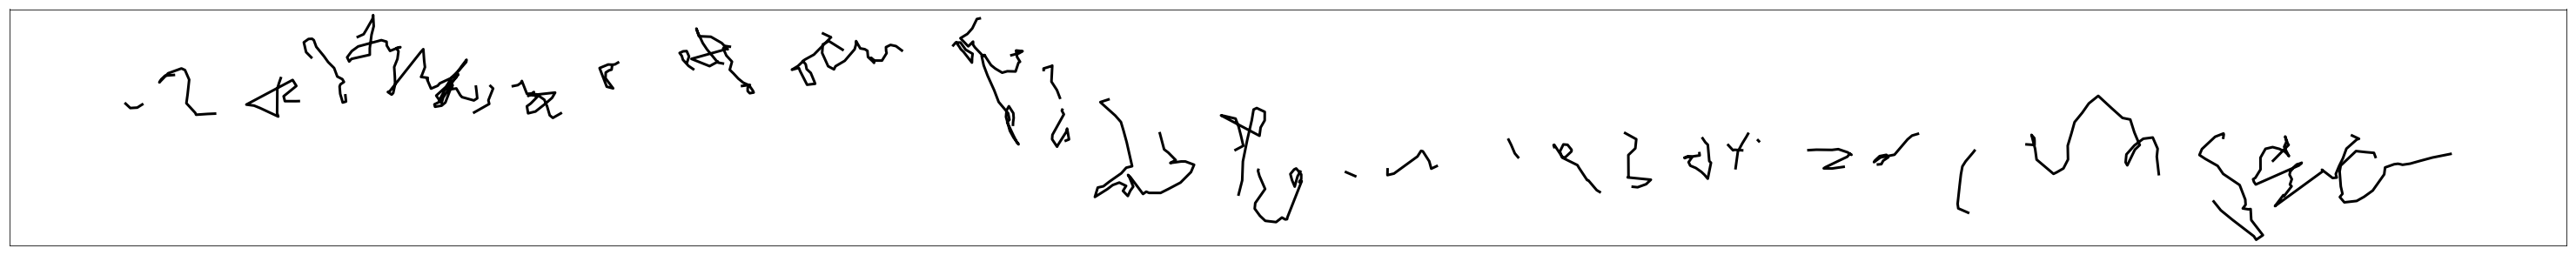

In [79]:
# test generation 60
s = generate_unconditionally(model,700,1)
plot_stroke(s)

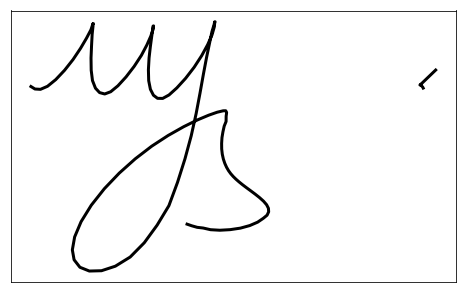

In [80]:
# test generation 60
g = greedy_generate(model)
g[650][0]=1
plot_stroke(g)

In [82]:
def control_generate(model, steps=700, random_seed=1, temp=.9):
    torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h1_init, c1_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    h2_init, c2_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h1_init = h1_init.cuda()
        c1_init = c1_init.cuda()
        h2_init = h2_init.cuda()
        c2_init = c2_init.cuda()
    x = Variable(zero_tensor)
    h1_init, c1_init = Variable(h1_init), Variable(c1_init)
    h2_init, c2_init = Variable(h2_init), Variable(c2_init)
    prev = (h1_init, c1_init)
    prev2 = (h2_init, c2_init)
    
    record = []
    # greedy but not the right generation
    for i in range(steps):        
        if np.random.random() < temp:
            end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev, prev2 = model(x, prev, prev2)
            prob_end = end.data[0][0][0]
            sample_end = np.round(prob_end)

            sample_index = np.argmax(weights.data[0][0].cpu().numpy())
            mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])

            out = np.array([sample_end, mu[0], mu[1]])
            record.append(out)
            x = torch.from_numpy(out).type(torch.FloatTensor)
            if cuda:
                x = x.cuda()
            x = Variable(x, requires_grad=False)
            x = x.view((1,1,3))
        
        else:
            end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, prev, prev2 = model(x, prev, prev2)
            prob_end = end.data[0][0][0]
            sample_end = np.random.binomial(1,prob_end)

            sample_index = np.random.choice(range(20),p = weights.data[0][0].cpu().numpy())
            mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])
            v1 = log_sigma_1.data[0][0][sample_index]**2
            v2 = log_sigma_2.data[0][0][sample_index]**2
            c = p.data[0][0][sample_index]*log_sigma_1.data[0][0][sample_index]*log_sigma_2.data[0][0][sample_index]
            cov = np.array([[v1,c],[c,v2]])
            sample_point = np.random.multivariate_normal(mu, cov)
            out = np.insert(sample_point,0,sample_end)
            record.append(out)
            x = torch.from_numpy(out).type(torch.FloatTensor)
            if cuda:
                x = x.cuda()
            x = Variable(x, requires_grad=False)
            x = x.view((1,1,3))
    return np.array(record)

In [ ]:
# test generation 30
s = generate_unconditionally(200,42)
plot_stroke(s)

In [ ]:
# test generation 30
g = greedy_generate()
g[650][0]=1
plot_stroke(g)


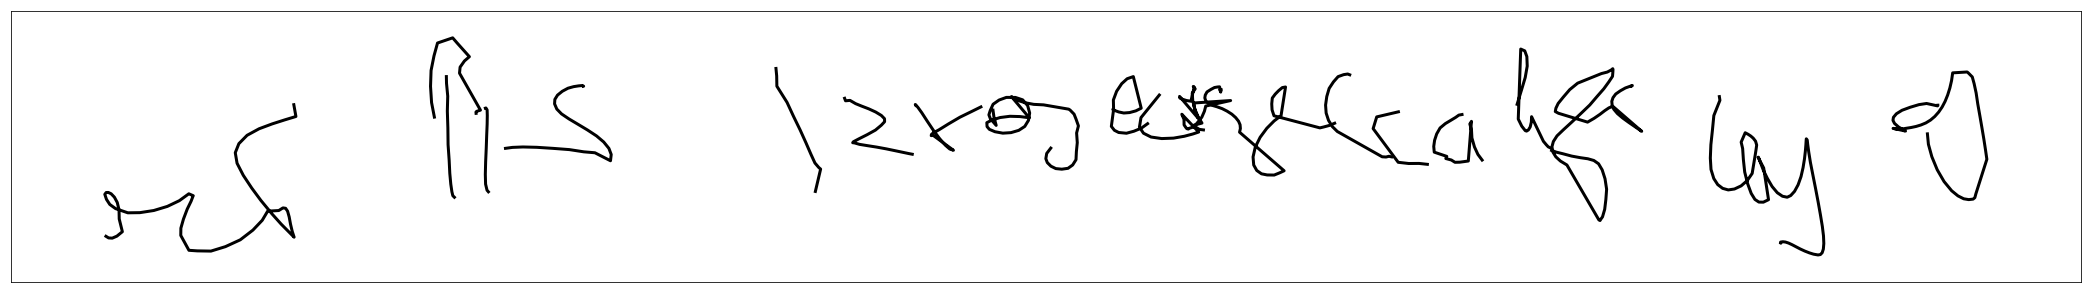

In [83]:
c = control_generate(model)
plot_stroke(c)